In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import clip
from PIL import Image
import time
from matplotlib.patches import Rectangle
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

In [37]:
def get_data(file_name):
    with open(file_name) as f:
        data = json.load(f)
    img_names = [[dt['id'], dt['file_name']] for dt in data['images']]
    imgToAnns = {ann['image_id']: [] for ann in data['annotations']}    
    for ann in data['annotations']:
        ann['caption'] = pre_process_text(ann['caption'])        
        imgToAnns[ann['image_id']] += [ann]                
    return img_names, imgToAnns


def pre_process_text(text):
    forbiden_char = "?.;:!,$#%/'()[]0123456789=´+-&@`" + '"'
    text = text.lower()
    text = "".join(u for u in text if u not in forbiden_char)
    return text

    
def clip_score(image_features, cap_features):
    score = image_features * cap_features
    score = torch.sum(score, -1)
    score = torch.maximum(score, torch.zeros_like(score))
    return score * 2.5

def clip_ref_score(image_features, cap_features, ref_features):
    c_score = clip_score(image_features, cap_features)
    r_score = []
    for c, r in zip(cap_features, ref_features):
        s = r @ c
        m = torch.max(s)
        r_score.append(torch.maximum(m, torch.zeros_like(m)))
    r_score = torch.stack(r_score)
    return 1/((1/c_score + 1/r_score)/2)

def cap_features(captions):
    text = clip.tokenize(captions).to(device)
    with torch.no_grad():
        features = model.encode_text(text)    
    return features / features.norm(dim=-1, keepdim=True)   

def rate_words(caption, img_feat):
    words = cap.split()
    l = len(words)
    caps = [cap]
    for i in range(l):
        caps.append(" ".join(words[0:i] + words[i+1:l]))
    caps_feat = cap_features(caps)
    score = clip_score(img_feat, caps_feat)
    ranks = torch.maximum(1-(score / score[0]), torch.zeros_like(score))[1:]
    return ranks, caps_feat[0]

def mask_objects(img_id):
    img = imread(path + data_mask[str(img_id)]["id_im"][1])
    imgs_masked = [img]
    imgs_clases = []
    for cl in set(data_mask[str(img_id)]['clases_im']):
        imgs_clases.append(cl)
        im = np.array(img)
        mask_pos = np.where(np.array(data_mask[str(img_id)]['clases_im']) == cl)[0]
        for pos in mask_pos:
            y1, x1, y2, x2 = data_mask[str(img_id)]['posiciones'][pos]
            im[y1:y2,x1:x2] = np.array([0,0,0]) if len(img.shape)==3 else 0
        imgs_masked.append(im)
    return imgs_masked, imgs_clases

def rank_objects(img_id, caps_feat):
    imgs_masked, imgs_clases = mask_objects(img_id)
    imgs_masked_feat = np.zeros((len(imgs_masked), 512))
    for i in range(len(imgs_masked)):
        im = Image.fromarray(imgs_masked[i])
        img = preprocess(im).unsqueeze(0).to(device)
        with torch.no_grad():
            imgs_masked_feat[i] = model.encode_image(img)
    imgs_masked_feat = torch.tensor(imgs_masked_feat, dtype=torch.float32)
    imgs_masked_feat /= imgs_masked_feat.norm(dim=-1, keepdim=True)  
    ranks = clip_score(imgs_masked_feat, caps_feat)
    return (ranks / ranks[0])[1:], imgs_clases

In [3]:
def get_cap_img(idx):
    img_id, img_fn = img_names[idx]
    img = imread(path + data_mask[str(img_id)]["id_im"][1])
    return img2anns[img_id][2]['caption'], img

In [4]:
with open("data-mask-rcnn-detections-5000.json") as f:
    data_mask = json.load(f)

In [5]:
data_file = '/data1/shared/COCO2017/annotations/captions_val2017.json'
path = '/data1/shared/COCO2017/val2017/'
img_names, img2anns = get_data(data_file)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load image features

In [8]:
#np.save("COCO2017_val_clip_features.npy", images_features)
images_features = np.load("COCO2017_val_clip_features.npy")
images_features = torch.tensor(images_features, dtype=torch.float32)

In [45]:
#Scores = []
for idx in range(654, 5000):
    img_id, img_fn = img_names[idx]
    cap = img2anns[img_id][2]['caption']
    words = cap.split()
    ranks_c, caps_feat = rate_words(cap, images_features[idx])
    P = torch.sum(ranks_c>0) / len(words)
    img = imread(path + data_mask[str(img_id)]["id_im"][1])
    imgs_masked, imgs_clases = mask_objects(img_id)
    ranks_i, img_clases = rank_objects(img_id, caps_feat)
    R = torch.sum((1 - ranks_i) > 0.1) / len(img_clases) if len(img_clases) != 0 else torch.tensor(1)
    F1 = 2*P*R/(P+R)
    Scores.append([P.numpy(),R.numpy(),F1.numpy()])
    if idx%50==0: 
        print(f"{idx}: P:{P} R:{R} F1:{F1}")

700: P:1.0 R:0.20000000298023224 F1:0.3333333134651184
750: P:0.75 R:0.0 F1:0.0
800: P:0.3333333432674408 R:0.0 F1:0.0
850: P:0.8888888955116272 R:1.0 F1:0.9411765336990356
900: P:0.6000000238418579 R:0.3333333432674408 F1:0.4285714328289032
950: P:0.8571428656578064 R:0.20000000298023224 F1:0.3243243396282196
1000: P:0.800000011920929 R:0.5 F1:0.6153846383094788
1050: P:0.4000000059604645 R:0.25 F1:0.3076923191547394
1100: P:0.7272727489471436 R:0.5 F1:0.5925925970077515
1150: P:0.800000011920929 R:0.3333333432674408 F1:0.4705882668495178
1200: P:0.699999988079071 R:0.0 F1:0.0
1250: P:0.5384615659713745 R:0.0 F1:0.0
1300: P:0.5 R:0.0 F1:0.0
1350: P:1.0 R:0.0 F1:0.0
1400: P:0.6363636255264282 R:0.25 F1:0.3589743673801422
1450: P:0.875 R:1.0 F1:0.9333333373069763
1500: P:0.6363636255264282 R:1.0 F1:0.7777777910232544
1550: P:0.8333333134651184 R:1.0 F1:0.9090909361839294
1600: P:0.3333333432674408 R:0.5 F1:0.4000000059604645
1650: P:0.7142857313156128 R:0.0 F1:0.0
1700: P:0.875 R:0.6666

In [46]:
np.save("COCO_val_Scores", np.array(Scores)) 

In [56]:
def show(idx):
    cap, img = get_cap_img(idx)
    img_id, img_fn = img_names[idx]
    print(data_mask[str(img_id)]['clases_im'])
    print(cap)
    plt.imshow(img)
    plt.show()
    print(Scores[idx])

['person', 'person', 'frisbee', 'stop sign', 'frisbee', 'frisbee']
two guys play flying disc golf in the woods


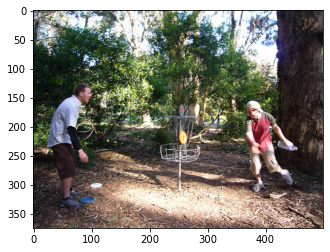

[array(0.22222222, dtype=float32), array(0., dtype=float32), array(0., dtype=float32)]


In [61]:
show(4600)

['broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'person', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli', 'broccoli']
the dinner on the plate is ready to eat 


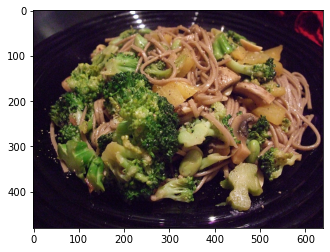

[array(0.5555556, dtype=float32), array(0., dtype=float32), array(0., dtype=float32)]


In [58]:
show(67)

['tv', 'bed', 'person', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book']
the living room is empty with the television on 


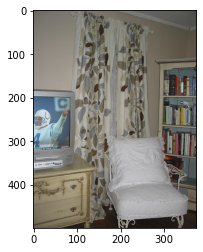

[array(0.33333334, dtype=float32), array(0.25, dtype=float32), array(0.28571427, dtype=float32)]


In [59]:
show(13)

['person', 'pizza', 'chair', 'dining table', 'person']
a girl takes a bite of her pepperoni pizza 


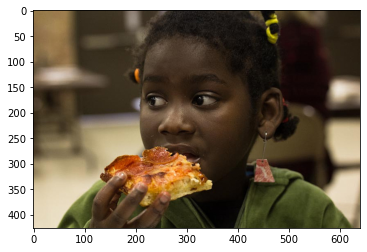

[array(1., dtype=float32), array(0.5, dtype=float32), array(0.6666667, dtype=float32)]


In [60]:
show(96)